In [5]:
# https://www.youtube.com/watch?v=VMj-3S1tku0

import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random

In [2]:
# HELPER FOR VISUALIZATION
# ------------------------

def trace(root): 
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [13]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

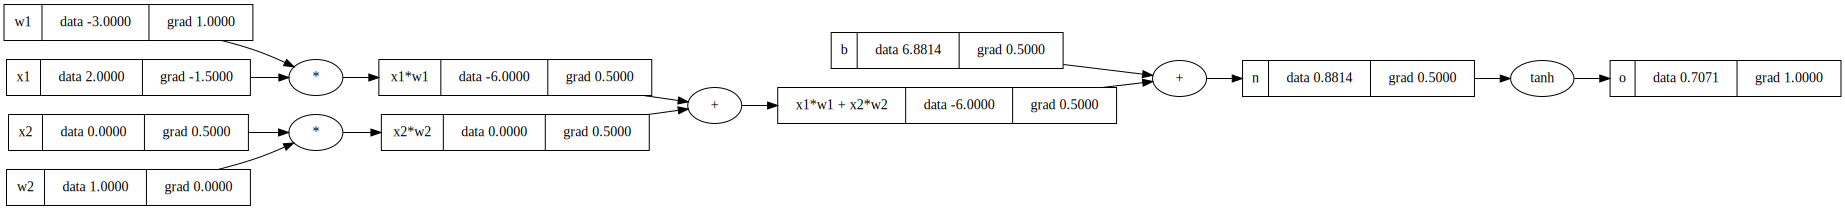

In [4]:
# for _ in range(20):

# GRAPH OF A SINGLE NEURON

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

# backprop
o.backward()

# visualize
draw_dot(o)

In [102]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# Little MLP
x = [2.0, 3.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=0.054178633400449434)

In [25]:
# draw_dot(mlp(x))

In [70]:
# Little dataset

# Input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1.0] 

In [109]:
# One training step:
# ------------------

# Current Predictions
ypred = [mlp(x) for x in xs]
print([y.data for y in ypred])

# Let`s define MSE loss here:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
print(f"Loss = {loss.data}")

# Let`s do a backward pass
for p in mlp.parameters():
    p.grad = 0.0
loss.backward()

# now we have gradients of loss with respect to all parameters, e.g:
some_neuron = mlp.layers[0].neurons[0]
print("Before:", some_neuron.w[0].data, some_neuron.w[0].grad)

# let`s do a gradient descent step
for p in mlp.parameters():
    p.data -= 0.05 * p.grad

# some_neuron = mlp.layers[0].neurons[0]
print("After: ", some_neuron.w[0].data, some_neuron.w[0].grad)

[0.7542054359558017, -0.9702611108670693, -0.9738876223940431, 0.9267144761207007]
Loss = 0.06735199351503768
Before: -0.04739242451147488 0.0035574949438011484
After:  -0.04757029925866493 0.0035574949438011484


In [111]:
mlp = MLP(3, [4, 4, 1])

for k in range(25):

    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data -= 0.05 * p.grad

    print(k, loss.data)

0 7.425681671630902
1 3.3774578043787633
2 2.533505310791414
3 1.8096326636809839
4 1.1093095994347564
5 0.6637541949054544
6 0.4413457441271397
7 0.32287754643765576
8 0.2519608471546164
9 0.20544903164194284
10 0.1728356001122766
11 0.14880436294722293
12 0.13041307855430415
13 0.11591323245595556
14 0.10420493396404637
15 0.09456366410587413
16 0.08649368956716304
17 0.07964486533253701
18 0.07376312386159219
19 0.06865980110812546
20 0.06419196443578029
21 0.06024941248617663
22 0.05674585587384
23 0.05361279416814827
24 0.050795176600763235
